# Classifier Optimization

In earlier exercises, we explored a variety of classifiers and feature selection techniques. During the past exercises we didn't pay much attention to the parameters of these procedures. In what follows we are going to investigate data-driven, unbiased techniques to optimize classification pipelines.

Cross-vaidation can allow us to pick the best performing parameters in in an unbiased fashion. We will be using the useful features from scikit-learn to build up some cross-validation analyses. scikit-learn also offers a simple procedure for building and automating the various steps involved in classifier optimization (e.g. data scaling => feature selection => parameter tuning). This is part of the [Pipeline package](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline). We will also explore these methods in this exercise.

## Goal of this script
>Build a pipeline of steps to optimize classifier performance.    
>Use the pipleline to make optimal choices.      

In [12]:
# Import libraries
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd

# Import machine learning libraries
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline


## Make preprocessing pipeline

In past weeks we have preprocessed the fMRI data from Kim et al. (2017) using the following steps:  
>Extract the BOLD data for a mask.  
>Get the the stimulus labels.  
>Assign a label to every TR.  
>Shift the label time course to take account of the hemodynamic lag.  
>Extract BOLD data only for the conditions of interest (ignore the TRs corresponding to the baseline).  
>Average stimuli within blocks in order to reduce concerns around temporal autocorrelation.

In general it can be useful to make a script that contains all of the functions you might use across multiple scripts. This is so that if you make an update to the function, you don't have to update all of the versions in the scripts that might otherwise define the function. Often these will be python scripts called *utils.py*

**Exercise 1:** Add all of the functions necessary for data handling (same as last assignment) to the *utils.py* script.

In [13]:
from utils import load_data, load_labels, label2TR, shift_timing, reshape_data, blockwise_sampling

Get the data from one participant ready for analysis

In [14]:
# Preset variables
dir = '/gpfs/milgram/data/cmhn-s18/datasets/vdc/'
num_runs=3
TR=1.5
hrf_lag = 4.5  # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(hrf_lag / TR) # Convert the shift into TRs

sub_id = 1

# Convert the number into a participant folder name
if (sub_id < 10):
    sids = '0' + str(sub_id)
else:
    sids = str(sub_id)   

# Specify the subject name
sub = 'sub-' + sids

# Load subject labels
stim_label_allruns = load_labels(dir, sub)

# Load the fMRI data
epi_mask_data_all = load_data(directory=dir, subject_name=sub, mask_name='', zscore_data=True)

# How many events are there on this run
_, events = stim_label_allruns.shape
events_run = int(events / num_runs)

# This can differ per participant
print(sub, '= TRs: ', epi_mask_data_all.shape[1], '; Voxels: ', epi_mask_data_all.shape[0])
TRs_run = int(epi_mask_data_all.shape[1] / num_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(stim_label_allruns, num_runs, TR, TRs_run, events_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data, labels = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Down sample the data to be blockwise rather than trialwise
bold_data, labels = blockwise_sampling(bold_data, labels)

Loaded  sub-01
Processing Start ...
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 = TRs:  930 ; Voxels:  177314
Expected blocks: 45; Resampled blocks: 45


## How big should a training set be?

When we split up our data into training and test sets we are trying to strike a balance between giving our classifier enough data to train a model with precise parameter estimates while ensuring that we also have enough data so that our test statistic has low variance. But what is that balance? Generally we use a rule of thumb that between 10% and 20% of our dataset should be the test. However, let's now investigate how different training set size affects classifier performance!

Aside: Not only do your training samples need to be independent, but so do your test samples. If the test samples are highly correlated then the effective number of test samples is lower and the test statistic variance will be higher.

In [15]:
# Run a basic n fold classification
def classification(classifier, data, labels, n_folds = 5, test_size=0.2):
    
    # How many folds of the classifier
    skfold = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size) 

    clf_score = np.array([])
    for train, test in skfold.split(data, labels):

        # Pull out the sample data
        train_data = data[train, :]
        test_data = data[test, :]
        
        # Train and test the classifier
        clf = classifier.fit(train_data, labels[train])
        clf_score = np.hstack((clf_score, clf.score(test_data, labels[test])))

    return clf_score.mean()

**Exercise 2:** Examine how the accuracy of the classifier changes with different test set sizes from 10% to 90% in 10% steps. Plot the results. Do this over 10 folds to decrease the variability of the results.

<IPython.core.display.Javascript object>


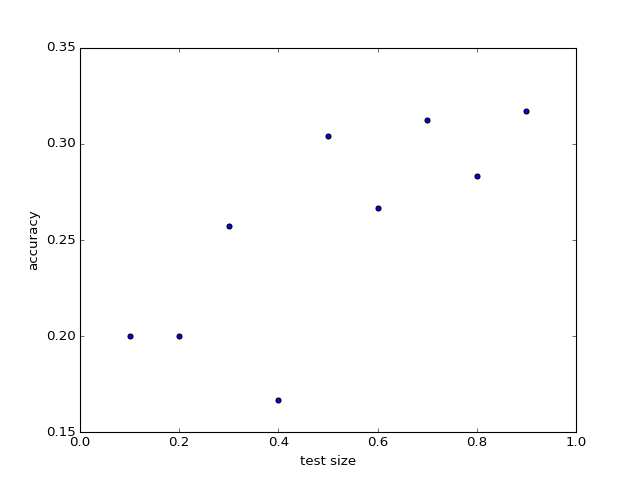

In [16]:
#Exercise 2

classifier = SVC(kernel="linear", C=0.0001)
steps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
test_results = []

for i in range(len(steps)):
    score_all = classification(classifier, bold_data, labels, test_size=steps[i])
    test_results.append(score_all)

plt.figure()
plt.scatter(steps, test_results)
plt.xlabel('test size')
plt.ylabel('accuracy')
plt.show()

## Cross-Validation: Hyper-parameter selection

Each of the classifiers we have used so far has one or more "hyper-parameters" used to configure and optimize the model based on the data and our goals. Click [here](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) for an explanation of the distinction between hyper-parameters and parameters. For instance, regularized logistic regression has a "penalty" hyper-parameter, which determines how much to emphasize the weight regularizing expression (e.g., L2 norm) when training the model.

**Exercise 3:** SVM has a "cost" hyper-parameter, briefly describe what it does:

**A:** Cost (C) is how much we penalize the SVM for data points within the margin (where "within" can also mean on the wrong side of the dividing hyperplane). For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. A lower C gives higher error on the training set and may even misclassify examples that are linearly separable, but it finds a larger margin that might be more robust.

From https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel and https://www.quora.com/What-is-the-intuition-behind-the-Cost-and-Gamma-parameters-in-SVM.

We want to pick the best cost hyper-parameter for our dataset and to do this we will use cross-validation. Each hyper-parameter can be considered as a dimension such that the set of hyper-parameters is a space to be searched for effective values. The GridSearchCV method in scikit-learn explores this space by dividing it up into a grid of values to be searched exhaustively. 

To give you an intuition for how grid search works, imagine trying to figure out what climate you find most comfortable. Let's say that there are two (hyper-)parameters that seem relevant: temperature and humidity. A given climate can be defined by the combination of values of these two parameters and you could report how comfortable you find this climate. A grid search would involve changing the value of each parameter with respect to the other in some fixed step size (e.g., 60 degrees and 50% humidity, 60 degrees and 60% humidity, 65 degrees and 60% humidity, etc.) and evaluating your preference for each combination.  

Note that the number of steps and hyper-parameters to search is up to you. But be aware of combinatorial explosion: the granularity of the search (the smaller the steps) and the number of hyper-parameters considered increases the search time exponentially.

GridSearchCV is an *extremely* useful tool for hyper-parameter optimization because it is very flexible. You can look at different values of a hyper-parameter, different kernels, different training/test split sizes, etc. The input is a dictionary where the key is the parameter of interest (the sides of the grid) and the values are the parameter increments to search over (the steps of the grid).

**Exercise 4:** Grid search can be slow because it returns results for all possible combinations of hyper-parameters. Can you think of a more efficient way to find the good hyper-parameter settings (Hint: How can you narrow the search?)

**A:** Suppose you have four parameters, A, B, C, and D. One could start by choosing arbitrary values for B-D and scanning along A. Find the optimal value of a for those B-D. Then hold A, C, and D fixed, and scan along B to find the optimum. Do the same for C and D while holding all other variables fixed. This avoids combinatorial explosion (for n values of each parameter and m parameters, you only have to test n x m combinations, instead of n^m combinations). However, it comes at the risk of missing global optima if your error surface is highly convoluted.


Below we are going to do a grid search over the SVM cost parameter and investigate the results.

In [17]:
# Search over different cost parameters
parameters = {'C':[0.01, 0.1, 1, 10]}
clf = GridSearchCV(SVC(kernel='linear'),
                   parameters,
                   cv=StratifiedShuffleSplit(n_splits=3, test_size=0.1))
clf.fit(bold_data, labels);

The output contains information about the best hyper-parameter

In [18]:
print(clf.best_estimator_)  # What was the best classifier and cost?
print(clf.best_score_) # What was the best classification score?

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.666666666667


Want to see more details from the cross validation? All the results are stored in the dictionary cv\_results\_. Let's took a look at some of the important metrics stored here. For more details you can look at the method on scikit-learn [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

You can printout cv\_results\_ directly or for a nicer look you can import it into a pandas dataframe and print it out. Each row corresponds to one parameter combination.

(Pandas is a widely used data processing and machine learning package. Some people love it more than the animal.)

In [19]:
# Ugly way
print(clf.cv_results_)

{'split1_test_score': array([ 0.2,  0.2,  0.2,  0.2]), 'rank_test_score': array([1, 1, 1, 1], dtype=int32), 'split0_train_score': array([ 1.,  1.,  1.,  1.]), 'std_test_score': array([ 0.33993463,  0.33993463,  0.33993463,  0.33993463]), 'split2_train_score': array([ 1.,  1.,  1.,  1.]), 'split2_test_score': array([ 0.8,  0.8,  0.8,  0.8]), 'mean_score_time': array([ 0.03670025,  0.03669246,  0.03672703,  0.03670406]), 'std_train_score': array([ 0.,  0.,  0.,  0.]), 'mean_train_score': array([ 1.,  1.,  1.,  1.]), 'split0_test_score': array([ 1.,  1.,  1.,  1.]), 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}], 'param_C': masked_array(data = [0.01 0.1 1 10],
             mask = [False False False False],
       fill_value = ?)
, 'mean_fit_time': array([ 0.48453387,  0.47234297,  0.47255286,  0.4717025 ]), 'std_score_time': array([  3.20694407e-05,   1.67870309e-05,   1.30243385e-05,
         1.60822124e-05]), 'split1_train_score': array([ 1.,  1.,  1.,  1.]), 'std_fit_time': a

In [20]:
# Nicer way
results = pd.DataFrame(clf.cv_results_)
print(results)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.484534         0.036700         0.666667               1.0    0.01   
1       0.472343         0.036692         0.666667               1.0     0.1   
2       0.472553         0.036727         0.666667               1.0       1   
3       0.471702         0.036704         0.666667               1.0      10   

        params  rank_test_score  split0_test_score  split0_train_score  \
0  {'C': 0.01}                1                1.0                 1.0   
1   {'C': 0.1}                1                1.0                 1.0   
2     {'C': 1}                1                1.0                 1.0   
3    {'C': 10}                1                1.0                 1.0   

   split1_test_score  split1_train_score  split2_test_score  \
0                0.2                 1.0                0.8   
1                0.2                 1.0                0.8   
2                0.2                 1.

/apps/hpc/Pypkgs/brainiak/0.5-anaconda/lib/python3.5/site-packages/scikit_learn-0.19.1-py3.5-linux-x86_64.egg/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/apps/hpc/Pypkgs/brainiak/0.5-anaconda/lib/python3.5/site-packages/scikit_learn-0.19.1-py3.5-linux-x86_64.egg/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/apps/hpc/Pypkgs/brainiak/0.5-anaconda/lib/python3.5/site-packages/scikit_learn-0.19.1-py3.5-linux-x86_64.egg/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be av

We are now going to do some different types of cross-validation hyper-parameter tuning.

**Exercise 5:** In machine learning, kernels are classes of algorithms that can be used to create a model. A radial basis function is a very common kernel in SVM classifiers. Briefly describe what it does:

**A:** Linearly non-separable features often become linearly separable after they are mapped to a high dimensional feature space. However, we don't ever need to compute the feature mappings explicitly: we only need to work with their kernels, which are easier to compute. Therefore, it's possible to create a very complex decision boundary based on a high dimensional (even infinite dimensional) feature mapping but still have an efficient computation because of the kernel representation.

An RBF kernel on two samples x and x', represented as feature vectors in some input space, is computed as the exponential of the squared Euclidean distance times some parameter -gamma. Since the value of the RBF kernel decreases with distance and ranges between zero (in the limit) and one (when x = x'), it has a ready interpretation as a similarity measure.

From http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex8/ex8.html and https://en.wikipedia.org/wiki/Radial_basis_function_kernel.

In [21]:
# Search over different cost and gamma parameters of a radial basis function
parameters = {'gamma':[10e-3, 10e0, 10e3], 'C':[10e-3, 10e0, 10e3]}
clf = GridSearchCV(SVC(kernel='rbf'),
                   parameters,
                   cv=StratifiedShuffleSplit(n_splits=3, test_size=0.1))
clf.fit(bold_data, labels)
print(clf.best_estimator_)  # What was the best classifier and parameters?
print(clf.best_score_) # What was the best classification score?

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.2


**Exercise 6:** Run an analysis in which you compare linear, polynomial, and RBF kernels for SVM using GridSearchCV. When would linear SVM be expected to outperform other kernels and why?

**A:** There are two main cases when linear SVM could outperform other kernels: if the data is linearly separable, or if you misparameterized your SVM (using the wrong gamma and/or cost parameters). There is no reason to say *a priori* that the RBF kernel is best; it just so happens that in most problems the RBF kernel performs best and so people tend to go for it more often than not.

From https://stats.stackexchange.com/questions/292480/why-does-svm-linear-kernel-outperforms-svm-rbf-kernel-in-terms-of-classification/292562.

In [22]:
#Exercise 6

parameters = {'kernel': ['linear', 'poly', 'rbf']}
clf = GridSearchCV(SVC(C=1.0),
                   parameters,
                   cv=StratifiedShuffleSplit(n_splits=3, test_size=0.1))
clf.fit(bold_data, labels)
print(clf.best_estimator_)  # What was the best classifier and parameters?
print(clf.best_score_) # What was the best classification score?

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.933333333333


When we are writing a classification pipeline, nested cross validation can be very useful. As the name suggests, this procedure nests a second cross-validation within folds of the first cross validation. As before, we will divide data into training and test sets (outer loop), but additionally will divide the training set itself in order to set the hyper-parameters into training and test (or validation) sets (inner loop).

Thus, on each split we now have a training (inner), validation (inner), and test (outer) dataset; a typical dataset size distribution might be 60%, 20%, 20%. Within the inner loop we train the model and find the optimal hyper-parameters (i.e., that have the highest performance when tested on the validation data). The typical practice is to then retrain your model with these hyper-parameters on both the training AND validation datasets and then evaluate on your held-out test dataset to get a score.

![image](https://qph.ec.quoracdn.net/main-qimg-bb7689c141427db9ab8ab030745aa8bc)

This is turtles all the way down, you could have any number of inner loops. However, you will run into data issues quickly (not enough for training) and you will also run the risk of over-fitting your data: you will find the optimal parameters for a small set of your data but this might not generalize to the rest of your data.

For more description and a good summary of what you have learnt so far then check [here](http://www.predictiveanalyticsworld.com/patimes/nested-cross-validation-simple-cross-validation-isnt-enough/8952/).

**Self-study:** Some people discourage training on both training and validation data, saying you should only ever use the training data for fitting the model. Figure out why these people hold these views.

**Exercise 7:** Set up a nested cross validation loop. In this loop you will perform hyper-parameter cross validation on a training dataset (which itself will be split into training and validation) and then score these optimized hyper-parameters on the test dataset. Loop through this 10 times and get the average accuracy overall. Note that the optimal hyper-parameter settings for each outer loop fold can be different.

In [23]:
#Exercise 7, adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

NUM_TRIALS = 10
svm = SVC(kernel="linear")

# Set up possible values of parameters to optimize over
p_grid = {"C": [0.01, 0.1, 1, 10]}

# Arrays to store scores
nested_scores = np.zeros(NUM_TRIALS)

# Run nested cross-validation
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(bold_data, labels)
    nested_score = cross_val_score(clf, X=bold_data, y=labels, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("Average accuracy on 10 trials in the outer loop is {0:6f} with std. dev. of {1:6f}."
      .format(nested_scores.mean(), nested_scores.std()))

Average accuracy on 10 trials in the outer loop is 0.744444 with std. dev. of 0.046878.


## How to avoid double dipping

One of the good things about the GridSearchCV method is that it makes it easy (but not impossible!) to prevent double dipping. In previous exercises we examined cases where double dipping is clear (e.g., training on all of the data and testing on a subset); however, double dipping can be a lot more subtle and harder to detect.

For instance, a common form of double dipping is Z scoring over both your training and testing datasets together, rather than Z scoring the two groups separately (in fact we are doing it in this exercise right now!). This is doubling dipping because information from one group affects the other. Imagine a scenario where you were using different runs as your test set. It might be that on a given run that the variability in activity is much higher than in all the other runs. By Z scoring over all runs you are decreasing the variability in all the other runs which could mask any patterns of variability. 

In practice, Z scoring can be unavoidable: if we have different runs but we don't want to use them as the basis for our training/test splits (for instance because there are practice effects) then we need to combine samples from different runs. Without normalization, these may have wildly different scales due to scanner drift or other confounds, distorting the classifier. Hence we need to normalize within run but this could be considered double dipping because each run includes both training and test data. Even without these concerns about different scales between runs, we might also worry about Z scoring over small numbers of observations in our test set. In the end, Z scoring is double dipping like jaywalking is illegal.

**Self-study:** Simulate an example where double dipping with Z scoring affects the results. (Hint: make observations  that are noisy samples of a given pattern of results where the amount of noise varies).


**Exercise 8:** If we do a 5 x 6 grid search is there a greater risk of double dipping than if we do a 3 x 2? Are there concerns with overfitting?

**A:** A grid search is not double dipping, regardless of the number of instances of each parameter, as long as the model training happens only on the test data. However, there could be concerns with overfitting: the more specifically we fit the model (i.e. with 5 or 6 possible values for each parameter, as opposed to 2 or 3), the greater risk we run that the precise parameters we end up with will not generalize well to the test data. 

Below we work through an exercise of another common type of double dipping in which we perform voxel selection on all of our data before splitting it into a training and test dataset

In [24]:
# How many folds of the classifier
n_folds = 100
test_size = 0.2
skfold = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size) 

clf_score = np.array([])
for train, test in skfold.split(bold_data, labels):
    
    # Do voxel selection on all voxels
    mean_threshold = np.percentile(np.mean(bold_data, axis = 0), 95)
    selected_voxels = np.where(mean_threshold <= np.mean(bold_data, axis = 0))
    
    # Pull out the sample data
    train_data = bold_data[train, :]
    test_data = bold_data[test, :]

    # Train and test the classifier
    classifier = SVC(kernel="linear", C=1)
    clf = classifier.fit(train_data[:, selected_voxels[0]], labels[train])
    score = clf.score(test_data[:, selected_voxels[0]], labels[test])
    clf_score = np.hstack((clf_score, score))

print(clf_score.mean())

0.827777777778


**Exercise 9:** Create a copy of this code that fixes the concerns about double dipping. 

In [25]:
#Exercise 9

# How many folds of the classifier
n_folds = 100
test_size = 0.2
skfold = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size) 

clf_score = np.array([])
for train, test in skfold.split(bold_data, labels):
    
    # Pull out the sample data
    train_data = bold_data[train, :]
    test_data = bold_data[test, :]
    
    # Do voxel selection on training voxels only
    mean_threshold = np.percentile(np.mean(train_data, axis = 0), 95)
    selected_voxels = np.where(mean_threshold <= np.mean(train_data, axis = 0))

    # Train and test the classifier
    classifier = SVC(kernel="linear", C=1)
    clf = classifier.fit(train_data[:, selected_voxels[0]], labels[train])
    score = clf.score(test_data[:, selected_voxels[0]], labels[test])
    clf_score = np.hstack((clf_score, score))

print(clf_score.mean())

0.815555555556


## Build a Pipeline

scikit-learn has a method, Pipeline, that simplifies running preprocessing steps in an automated fashion. Below we create a pipeline with the following steps:
>Scale the data.  
>Use PCA and choose the best option from a set of dimensions.  
>Choose the best cost for an SVM.

It is then really easy to do cross validation at different levels of this pipeline.

The steps below are based on this example in scikit-learn: http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#illustration-of-pipeline-and-gridsearchcv

In [26]:
# Set up the pipeline
pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('reduce_dim', PCA()),
        ('classify', SVC(kernel="linear")),
    ])

# PCA dimensions
component_steps = [20, 40]

# Classifier cost options
c_steps = [10e-1, 10e0, 10e1, 10e2]

# Build the grid search dictionary
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)], 
        'reduce_dim__n_components': component_steps,
        'classify__C': c_steps,
    },
]

Now we are going to put it all together and run the pipeline

In [27]:
# parallelization parameter, will return to this later...
n_jobs=1;

clf_pipe = GridSearchCV(pipe, cv=3, n_jobs=n_jobs, param_grid=param_grid)
clf_pipe.fit(bold_data, labels);

print(clf_pipe.best_estimator_)  # What was the best classifier and parameters?
print(clf_pipe.best_score_) # What was the best classification score?

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, iterated_power=7, n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
0.6


In [28]:
# What was the best classifier and parameters?
cv_results = pd.DataFrame(clf_pipe.cv_results_)

# What was the best classification score?
print(cv_results.sort_values(by='mean_test_score', ascending=False))

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
1       0.390021         0.018657         0.600000               1.0   
3       0.391802         0.018659         0.600000               1.0   
5       0.388710         0.018608         0.600000               1.0   
7       0.389886         0.018628         0.600000               1.0   
0       0.942122         0.019499         0.466667               1.0   
2       0.901483         0.019129         0.466667               1.0   
4       0.901486         0.019492         0.466667               1.0   
6       0.900900         0.019137         0.466667               1.0   

  param_classify__C                                   param_reduce_dim  \
1                 1  PCA(copy=True, iterated_power=7, n_components=...   
3                10  PCA(copy=True, iterated_power=7, n_components=...   
5               100  PCA(copy=True, iterated_power=7, n_components=...   
7              1000  PCA(copy=True, iterated_power=7, n

/apps/hpc/Pypkgs/brainiak/0.5-anaconda/lib/python3.5/site-packages/scikit_learn-0.19.1-py3.5-linux-x86_64.egg/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/apps/hpc/Pypkgs/brainiak/0.5-anaconda/lib/python3.5/site-packages/scikit_learn-0.19.1-py3.5-linux-x86_64.egg/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/apps/hpc/Pypkgs/brainiak/0.5-anaconda/lib/python3.5/site-packages/scikit_learn-0.19.1-py3.5-linux-x86_64.egg/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be av

**Exercise 10:** Build a pipeline that takes the following steps:

1. Z score the data.  
2. Grid search over PCA and the VarianceThreshold method for voxel selection.  
3. Grid search over the linear and RBF SVM kernel.

Run this pipeline for at least 5 subjects and present your average results.

In [36]:
# Exercise 10

# Set up the pipeline
pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('reduce_dim', PCA()),
        ('classify', SVC()),
    ])

# PCA dimensions
component_steps = [20, 40]

# Classifier cost options
c_steps = [10e-1, 10e0, 10e1]

#threshold
var_threshold = np.percentile(np.std(bold_data, axis=0) ** 2, 95)

#kernels
kernel_types = ['linear', 'rbf']

# Build the grid search dictionary
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': component_steps,
        'classify__C': c_steps,
    },
    {
        'reduce_dim': [VarianceThreshold(threshold=var_threshold)],
        'classify__C': c_steps,
    },
    {
        'classify__kernel': kernel_types
    },
]

In [37]:
def load_subj_data(sub_id):
    
    dir = '/gpfs/milgram/data/cmhn-s18/datasets/vdc/'

    # Convert the number into a participant folder name
    if (sub_id < 10):
        sids = '0' + str(sub_id)
    else:
        sids = str(sub_id)   

    # Specify the subject name
    sub = 'sub-' + sids

    # Load subject labels
    stim_label_allruns = load_labels(dir, sub)

    # Load the fMRI data
    epi_mask_data_all = load_data(directory=dir, subject_name=sub, mask_name='', zscore_data=True)

    # How many events are there on this run
    _, events = stim_label_allruns.shape
    events_run = int(events / num_runs)

    # This can differ per participant
    print(sub, '= TRs: ', epi_mask_data_all.shape[1], '; Voxels: ', epi_mask_data_all.shape[0])
    TRs_run = int(epi_mask_data_all.shape[1] / num_runs)

    # Convert the timing into TR indexes
    stim_label_TR = label2TR(stim_label_allruns, num_runs, TR, TRs_run, events_run)

    # Shift the data some amount
    stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

    # Perform the reshaping of the data
    bold_data, labels = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

    # Down sample the data to be blockwise rather than trialwise
    bold_data, labels = blockwise_sampling(bold_data, labels)
    
    return bold_data, labels

In [38]:
n_subjs=5

clf_pipe = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
best_scores = np.zeros((n_subjs))

for i in range(n_subjs):
    bold_data, labels = load_subj_data(i+1)
    clf_pipe.fit(bold_data, labels);

    # What was the best classification score?
    best_scores[i] = clf_pipe.best_score_
    print(clf_pipe.best_score_)

Loaded  sub-01
Processing Start ...
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 = TRs:  930 ; Voxels:  177314
Expected blocks: 45; Resampled blocks: 45
0.6
Loaded  sub-02
Processing Start ...
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r3.nii
sub-02 = TRs:  933 ; Voxels:  232022
Expected blocks: 45; Resampled blocks: 45
0.466666666667
Loaded  sub-03
Processing Start ...
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-03/preprocessed/

In [48]:
print(clf_pipe.best_estimator_)  # What was the best classifier and parameters?
print(best_scores)
print("Average accuracy on {} subjects is {} with std. dev. of {}."
      .format(n_subjs, best_scores.mean(), best_scores.std()))

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power=7, n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
[ 0.6         0.46666667  0.53333333  0.48888889  0.73333333]
Average accuracy on 5 subjects is 0.5644444444444445 with std. dev. of 0.09594236953299065.


**Novel contribution:** be creative and make one new discovery by adding an analysis, visualization, or optimization.



In [41]:
# Show that the pipeline results are far worse when we don't z-score

# no scaling!!!
pipe = Pipeline([
        ('reduce_dim', PCA()),
        ('classify', SVC(kernel="linear")),
    ])

# PCA dimensions
component_steps = [20, 40]

# Classifier cost options
c_steps = [10e-1, 10e0, 10e1]

# Build the grid search dictionary
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)], 
        'reduce_dim__n_components': component_steps,
        'classify__C': c_steps,
    },
]

clf_pipe = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
clf_pipe.fit(bold_data, labels);

print(clf_pipe.best_estimator_)  # What was the best classifier and parameters?
print(clf_pipe.best_score_) # What was the best classification score?

#Note that this score is inferior to the classification accuracy on subject 5 above

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power=7, n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
0.688888888889
